In [4]:
!pip install torchinfo

# Import Liabraries

In [5]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
import seaborn as sns

In [6]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla T4


In [7]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = "/kaggle/input/taeleaf-dataset"
output_dir = "/kaggle/working/processed-dataset"  
checkpoints_path = "/kaggle/working/"
os.makedirs(output_dir, exist_ok=True)

train_batch = 32
test_batch = 16
total_class = 3
learning_rate = 0.0001
decay = 1e-4
epoch = 100
patience = 100

In [8]:
def load_split(split_dir):
    file_paths, labels = [], []
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                file_paths.append(os.path.join(class_dir, image_name))
                labels.append(class_name)
    return pd.DataFrame({"file_path": file_paths, "label": labels})

data = load_split(os.path.join(data_dir, "/kaggle/input/taeleaf-dataset"))

In [9]:
train_dataframe, temp_dataframe = train_test_split(
    data, 
    test_size=0.30, 
    stratify=data['label'], 
    random_state=42
)

validation_dataframe, test_dataframe = train_test_split(
    temp_dataframe, 
    test_size=0.50, 
    stratify=temp_dataframe['label'], 
    random_state=42
)

Dataset Split Ratios
Train: 522 images (69.88%)
Test: 113 images (15.13%)
Validation: 112 images (14.99%)


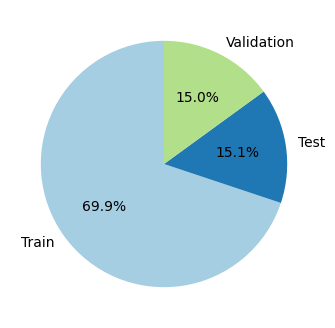

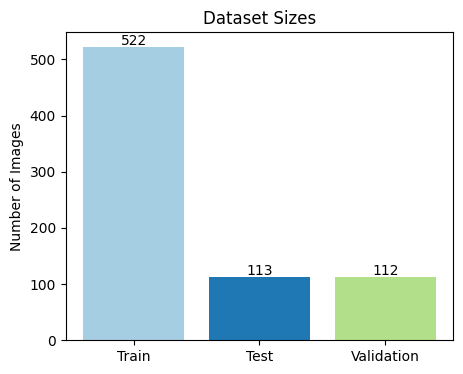

In [10]:
sizes = {
    "Train": len(train_dataframe),
    "Test": len(test_dataframe),
    "Validation": len(validation_dataframe)
}

total = sum(sizes.values())
ratios = {k: (v / total) * 100 for k, v in sizes.items()}

print("Dataset Split Ratios")
for split in sizes.keys():
    print(f"{split}: {sizes[split]} images ({ratios[split]:.2f}%)")

plt.figure(figsize=(4, 4))
plt.pie(
    sizes.values(),
    labels=sizes.keys(),
    autopct="%.1f%%",
    startangle=90,
    colors=["#a6cee3", "#1f78b4", "#b2df8a"]
)
plt.show()

plt.figure(figsize=(5, 4))
plt.bar(sizes.keys(), sizes.values(), color=["#a6cee3", "#1f78b4", "#b2df8a"])
plt.ylabel("Number of Images")
plt.title("Dataset Sizes")
y_max = max(sizes.values()) * 1.05 
plt.ylim(0, y_max)
for i, v in enumerate(sizes.values()):
    plt.text(i, v + total*0.005, str(v), ha='center')  
plt.show()

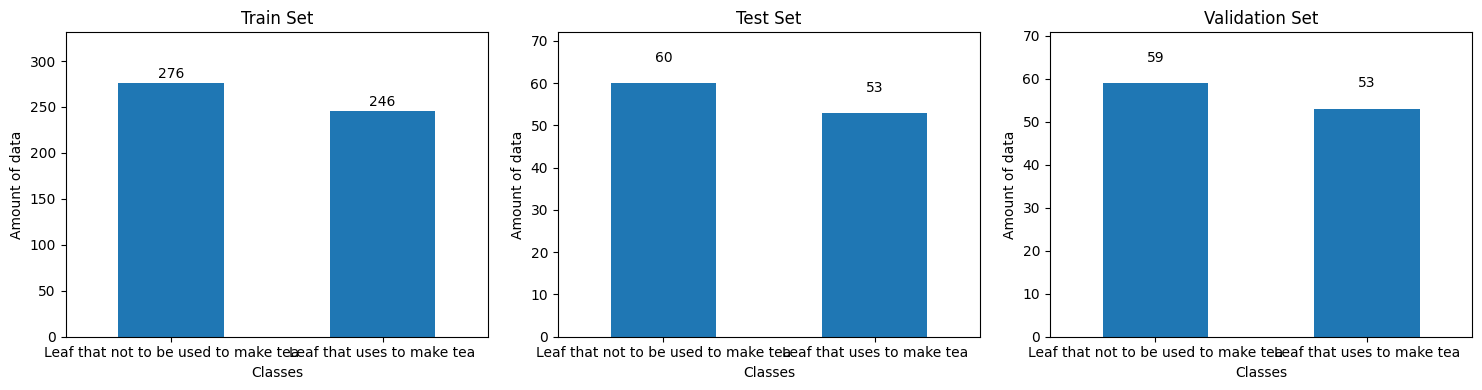

In [11]:
def class_distribution(train_df, test_df, val_df):
    datasets = {
        "Train": train_df,
        "Test": test_df,
        "Validation": val_df
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for ax, (split_name, df) in zip(axes, datasets.items()):
        class_counts = df['label'].value_counts()

        class_counts.plot(kind='bar', ax=ax)
        ax.set_xlabel('Classes')
        ax.set_ylabel('Amount of data')
        ax.set_title(f'{split_name} Set')
        ax.set_xticks(range(len(class_counts)))
        ax.set_xticklabels(class_counts.index, rotation=360)
        
        for i, count in enumerate(class_counts):
            ax.text(i, count + 5, str(count), ha='center')
        ax.set_ylim(0, max(class_counts) * 1.2)
    
    plt.tight_layout()
    plt.show()

class_distribution(train_dataframe, test_dataframe, validation_dataframe)

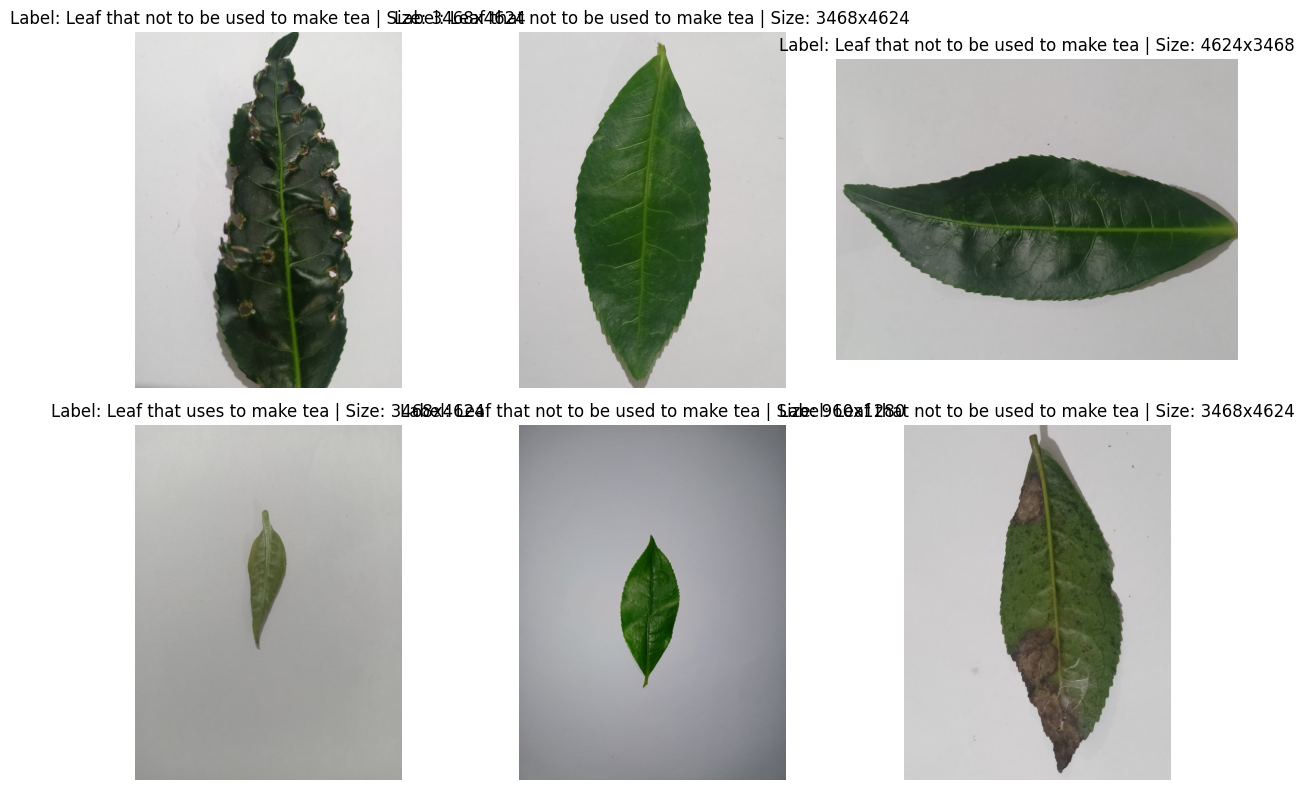

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  
axes = axes.flatten() 

for ax in axes:
    random_index = random.randint(0, len(train_dataframe) - 1)
    random_row = train_dataframe.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    width, height = image.size

    ax.imshow(image)
    ax.set_title(f"Label: {label} | Size: {width}x{height}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
sample_image_path = train_dataframe['file_path'].iloc[0]
img = Image.open(sample_image_path)
num_channels = len(img.getbands())
print(f"Number of channels: {num_channels}")

Number of channels: 3


In [14]:
def data_preprocess(df, split_name, size=(224, 224), quality=100):
    split_dir = os.path.join(output_dir, split_name)
    os.makedirs(split_dir, exist_ok=True)

    processed_file_paths = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        label = row['label']
        label_dir = os.path.join(split_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        img = Image.open(row['file_path']).convert("RGB")  
        img = img.resize(size, Image.Resampling.LANCZOS)

        file_name = os.path.basename(row['file_path'])
        save_path = os.path.join(label_dir, file_name)
        img.save(save_path, optimize=True, quality=quality)

        processed_file_paths.append(save_path)

    df['file_path'] = processed_file_paths
    return df

train_dataframe = data_preprocess(train_dataframe, "train")
validation_dataframe = data_preprocess(validation_dataframe, "val")
test_dataframe = data_preprocess(test_dataframe, "test")

Processing test: 100%|██████████| 113/113 [00:34<00:00,  3.32it/s]


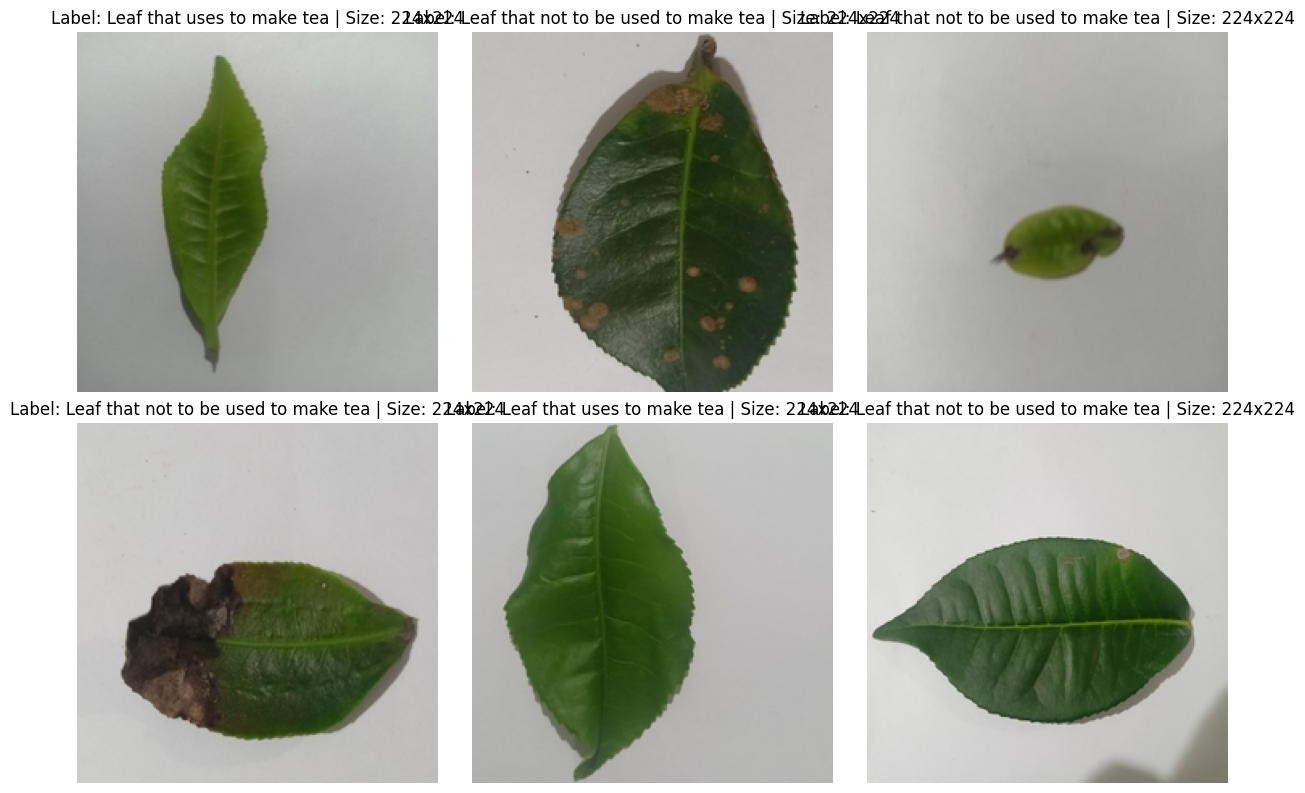

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  
axes = axes.flatten() 

for ax in axes:
    random_index = random.randint(0, len(train_dataframe) - 1)
    random_row = train_dataframe.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    width, height = image.size

    ax.imshow(image)
    ax.set_title(f"Label: {label} | Size: {width}x{height}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        unique_labels = sorted(self.dataframe['label'].unique())
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [17]:
def data_transfrom():

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_transform = transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        validation_dataframe,
        transform,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_dataframe,
        transform,
        is_lb=True
    )

    print("Label encoding:")
    for label, idx in train_dataset.label_map.items():
        print(f"{label} -> {idx}")
        
    train_dataloader = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    validation_dataloader = DataLoader(valid_dataset, batch_size = test_batch, shuffle=False, num_workers=2)
    test_dataloader = DataLoader(test_dataset, batch_size = test_batch, shuffle=False, num_workers=2)

    return train_dataloader, validation_dataloader, test_dataloader

train_dataloader, validation_dataloader, test_dataloader = data_transfrom()

Label encoding:
Leaf that not to be used to make tea -> 0
Leaf that uses to make tea -> 1


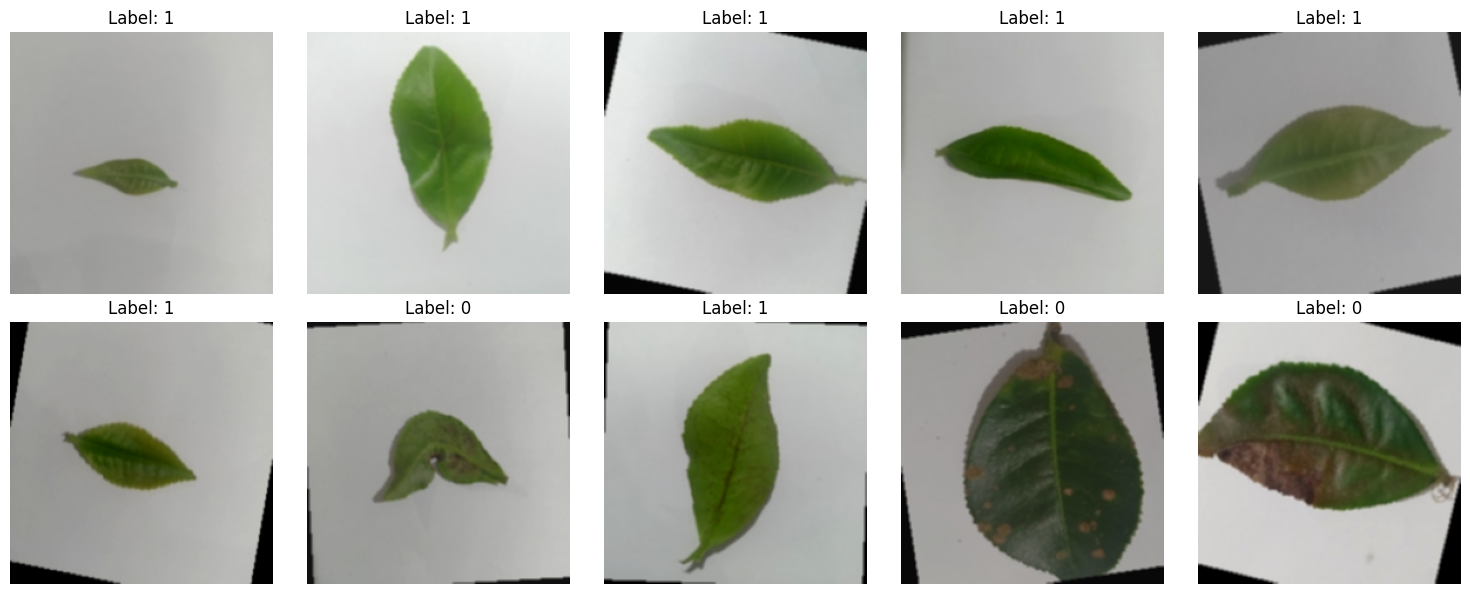

In [18]:
def augmented_samples(dataloader, num_images=10):
    images, labels = next(iter(dataloader))  

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    images = torch.clamp(images, 0, 1)  

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i >= num_images:
            break
        img = images[i].permute(1, 2, 0).cpu().numpy() 
        label = labels[i].item()
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

augmented_samples(train_dataloader)

In [19]:
class TeaLeafNet(nn.Module):
    def __init__(self, num_classes):
        super(TeaLeafNet, self).__init__()
        
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 112x112
            
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 56x56
            
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 28x28
            
            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 14x14
            
            # Conv Block 5
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 7x7
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [20]:
num_classes = total_class  
model = TeaLeafNet(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(train_batch, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
TeaLeafNet                               [32, 3]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 32, 224, 224]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 224, 224]        64
│    └─ReLU: 2-3                         [32, 32, 224, 224]        --
│    └─MaxPool2d: 2-4                    [32, 32, 112, 112]        --
│    └─Conv2d: 2-5                       [32, 64, 112, 112]        18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 112, 112]        128
│    └─ReLU: 2-7                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-8                    [32, 64, 56, 56]          --
│    └─Conv2d: 2-9                       [32, 128, 56, 56]         73,856
│    └─BatchNorm2d: 2-10                 [32, 128, 56, 56]         256
│    └─ReLU: 2-11                        [32, 128, 56, 56]         --
│   

In [21]:
start_time = time.time()

def train_model(model, criterion, optimizer, train_dataloader, validation_dataloader, num_epochs=epoch, early_stop_patience=patience, checkpoints_path="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in validation_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{checkpoints_path}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
            print(f"EARLY STOP COUNTER {consecutive_no_improvement} (NO IMPROVEMENT IN VALIDATION ACCURACY)")

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
            print(f"EARLY STOP COUNTER {num_epochs_loss_greater} (VALIDATION LOSS IS HIGHER)")
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, train_dataloader, validation_dataloader, checkpoints_path=checkpoints_path)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_logs.xlsx', index=False)

Epoch 1/100: 100%|██████████| 17/17 [00:02<00:00,  5.86it/s, acc=0.67, loss=0.937] 

Training Loss: 0.937 Acc: 0.670


Validation Loss: 1.268 Acc: 0.473
Best model saved at epoch 1 with validation accuracy: 0.473
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 2/100: 100%|██████████| 17/17 [00:02<00:00,  6.69it/s, acc=0.835, loss=0.494]

Training Loss: 0.494 Acc: 0.835


Validation Loss: 0.342 Acc: 0.884
Best model saved at epoch 2 with validation accuracy: 0.884


Epoch 3/100: 100%|██████████| 17/17 [00:02<00:00,  6.73it/s, acc=0.849, loss=0.44] 

Training Loss: 0.440 Acc: 0.849


Validation Loss: 0.437 Acc: 0.884
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 4/100: 100%|██████████| 17/17 [00:02<00:00,  6.63it/s, acc=0.889, loss=0.304]

Training Loss: 0.304 Acc: 0.889


Validation Loss: 0.263 Acc: 0.884
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 5/100: 100%|██████████| 17/17 [00:02<00:00,  6.77it/s, acc=0.887, loss=0.317]

Training Loss: 0.317 Acc: 0.887


Validation Loss: 0.520 Acc: 0.857
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 6/100: 100%|██████████| 17/17 [00:02<00:00,  6.74it/s, acc=0.935, loss=0.195]

Training Loss: 0.195 Acc: 0.935


Validation Loss: 0.365 Acc: 0.866
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 7/100: 100%|██████████| 17/17 [00:02<00:00,  7.09it/s, acc=0.916, loss=0.208]

Training Loss: 0.208 Acc: 0.916


Validation Loss: 0.362 Acc: 0.875
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 8/100: 100%|██████████| 17/17 [00:02<00:00,  7.06it/s, acc=0.927, loss=0.179]

Training Loss: 0.179 Acc: 0.927


Validation Loss: 0.260 Acc: 0.911
Best model saved at epoch 8 with validation accuracy: 0.911
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 9/100: 100%|██████████| 17/17 [00:02<00:00,  6.99it/s, acc=0.935, loss=0.193]

Training Loss: 0.193 Acc: 0.935


Validation Loss: 0.518 Acc: 0.839
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 10/100: 100%|██████████| 17/17 [00:02<00:00,  6.61it/s, acc=0.908, loss=0.253]

Training Loss: 0.253 Acc: 0.908


Validation Loss: 0.284 Acc: 0.920
Best model saved at epoch 10 with validation accuracy: 0.920
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 11/100: 100%|██████████| 17/17 [00:02<00:00,  6.94it/s, acc=0.929, loss=0.184]

Training Loss: 0.184 Acc: 0.929


Validation Loss: 0.338 Acc: 0.866
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 7 (VALIDATION LOSS IS HIGHER)


Epoch 12/100: 100%|██████████| 17/17 [00:02<00:00,  6.73it/s, acc=0.941, loss=0.174]

Training Loss: 0.174 Acc: 0.941


Validation Loss: 0.195 Acc: 0.946
Best model saved at epoch 12 with validation accuracy: 0.946
EARLY STOP COUNTER 8 (VALIDATION LOSS IS HIGHER)


Epoch 13/100: 100%|██████████| 17/17 [00:02<00:00,  6.80it/s, acc=0.929, loss=0.18] 

Training Loss: 0.180 Acc: 0.929


Validation Loss: 0.151 Acc: 0.973
Best model saved at epoch 13 with validation accuracy: 0.973


Epoch 14/100: 100%|██████████| 17/17 [00:02<00:00,  6.75it/s, acc=0.923, loss=0.232]

Training Loss: 0.232 Acc: 0.923


Validation Loss: 0.526 Acc: 0.848
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 15/100: 100%|██████████| 17/17 [00:02<00:00,  6.74it/s, acc=0.954, loss=0.141]

Training Loss: 0.141 Acc: 0.954


Validation Loss: 0.307 Acc: 0.893
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 16/100: 100%|██████████| 17/17 [00:02<00:00,  6.96it/s, acc=0.956, loss=0.118]

Training Loss: 0.118 Acc: 0.956


Validation Loss: 0.202 Acc: 0.920
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 17/100: 100%|██████████| 17/17 [00:02<00:00,  7.04it/s, acc=0.944, loss=0.156]

Training Loss: 0.156 Acc: 0.944


Validation Loss: 0.511 Acc: 0.830
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 18/100: 100%|██████████| 17/17 [00:02<00:00,  6.91it/s, acc=0.956, loss=0.136]

Training Loss: 0.136 Acc: 0.956


Validation Loss: 0.189 Acc: 0.955
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 19/100: 100%|██████████| 17/17 [00:02<00:00,  6.97it/s, acc=0.962, loss=0.112]

Training Loss: 0.112 Acc: 0.962


Validation Loss: 0.294 Acc: 0.920
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 20/100: 100%|██████████| 17/17 [00:02<00:00,  6.70it/s, acc=0.948, loss=0.113]

Training Loss: 0.113 Acc: 0.948


Validation Loss: 0.120 Acc: 0.982
Best model saved at epoch 20 with validation accuracy: 0.982
EARLY STOP COUNTER 7 (VALIDATION LOSS IS HIGHER)


Epoch 21/100: 100%|██████████| 17/17 [00:02<00:00,  6.92it/s, acc=0.939, loss=0.175]

Training Loss: 0.175 Acc: 0.939


Validation Loss: 0.157 Acc: 0.982
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 22/100: 100%|██████████| 17/17 [00:02<00:00,  6.66it/s, acc=0.967, loss=0.109] 

Training Loss: 0.109 Acc: 0.967


Validation Loss: 0.138 Acc: 0.964
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 23/100: 100%|██████████| 17/17 [00:02<00:00,  6.56it/s, acc=0.96, loss=0.114] 

Training Loss: 0.114 Acc: 0.960


Validation Loss: 0.311 Acc: 0.893
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 24/100: 100%|██████████| 17/17 [00:02<00:00,  7.08it/s, acc=0.96, loss=0.107]  

Training Loss: 0.107 Acc: 0.960


Validation Loss: 0.092 Acc: 0.982
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 25/100: 100%|██████████| 17/17 [00:02<00:00,  6.64it/s, acc=0.943, loss=0.16] 

Training Loss: 0.160 Acc: 0.943


Validation Loss: 0.150 Acc: 0.973
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 26/100: 100%|██████████| 17/17 [00:02<00:00,  6.85it/s, acc=0.967, loss=0.0986]

Training Loss: 0.099 Acc: 0.967


Validation Loss: 0.150 Acc: 0.982
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 27/100: 100%|██████████| 17/17 [00:02<00:00,  6.70it/s, acc=0.95, loss=0.157] 

Training Loss: 0.157 Acc: 0.950


Validation Loss: 0.122 Acc: 0.973
EARLY STOP COUNTER 7 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 28/100: 100%|██████████| 17/17 [00:02<00:00,  7.10it/s, acc=0.966, loss=0.103] 

Training Loss: 0.103 Acc: 0.966


Validation Loss: 0.149 Acc: 0.973
EARLY STOP COUNTER 8 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 29/100: 100%|██████████| 17/17 [00:02<00:00,  6.93it/s, acc=0.962, loss=0.1]   

Training Loss: 0.100 Acc: 0.962


Validation Loss: 0.128 Acc: 0.973
EARLY STOP COUNTER 9 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 30/100: 100%|██████████| 17/17 [00:02<00:00,  6.95it/s, acc=0.962, loss=0.0981]

Training Loss: 0.098 Acc: 0.962


Validation Loss: 0.224 Acc: 0.920
EARLY STOP COUNTER 10 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 31/100: 100%|██████████| 17/17 [00:02<00:00,  6.60it/s, acc=0.956, loss=0.109] 

Training Loss: 0.109 Acc: 0.956


Validation Loss: 0.085 Acc: 0.982
EARLY STOP COUNTER 11 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 32/100: 100%|██████████| 17/17 [00:02<00:00,  7.03it/s, acc=0.962, loss=0.113]

Training Loss: 0.113 Acc: 0.962


Validation Loss: 0.295 Acc: 0.902
EARLY STOP COUNTER 12 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 33/100: 100%|██████████| 17/17 [00:02<00:00,  6.92it/s, acc=0.973, loss=0.0634]

Training Loss: 0.063 Acc: 0.973


Validation Loss: 0.133 Acc: 0.964
EARLY STOP COUNTER 13 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 34/100: 100%|██████████| 17/17 [00:02<00:00,  6.78it/s, acc=0.971, loss=0.0647]

Training Loss: 0.065 Acc: 0.971


Validation Loss: 0.367 Acc: 0.875
EARLY STOP COUNTER 14 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 35/100: 100%|██████████| 17/17 [00:02<00:00,  6.89it/s, acc=0.964, loss=0.118]

Training Loss: 0.118 Acc: 0.964


Validation Loss: 0.110 Acc: 0.964
EARLY STOP COUNTER 15 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 36/100: 100%|██████████| 17/17 [00:02<00:00,  6.57it/s, acc=0.971, loss=0.0782]

Training Loss: 0.078 Acc: 0.971


Validation Loss: 0.314 Acc: 0.866
EARLY STOP COUNTER 16 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 37/100: 100%|██████████| 17/17 [00:02<00:00,  6.71it/s, acc=0.981, loss=0.0815]

Training Loss: 0.081 Acc: 0.981


Validation Loss: 0.204 Acc: 0.929
EARLY STOP COUNTER 17 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 38/100: 100%|██████████| 17/17 [00:02<00:00,  6.87it/s, acc=0.969, loss=0.0698]

Training Loss: 0.070 Acc: 0.969


Validation Loss: 0.209 Acc: 0.938
EARLY STOP COUNTER 18 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 39/100: 100%|██████████| 17/17 [00:02<00:00,  6.99it/s, acc=0.971, loss=0.0767]

Training Loss: 0.077 Acc: 0.971


Validation Loss: 0.125 Acc: 0.991
Best model saved at epoch 39 with validation accuracy: 0.991
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 40/100: 100%|██████████| 17/17 [00:02<00:00,  7.03it/s, acc=0.966, loss=0.0844]

Training Loss: 0.084 Acc: 0.966


Validation Loss: 0.130 Acc: 0.973
EARLY STOP COUNTER 1 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 41/100: 100%|██████████| 17/17 [00:02<00:00,  6.84it/s, acc=0.977, loss=0.059] 

Training Loss: 0.059 Acc: 0.977


Validation Loss: 0.122 Acc: 0.973
EARLY STOP COUNTER 2 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 42/100: 100%|██████████| 17/17 [00:02<00:00,  6.88it/s, acc=0.977, loss=0.0554]

Training Loss: 0.055 Acc: 0.977


Validation Loss: 0.085 Acc: 0.982
EARLY STOP COUNTER 3 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 7 (VALIDATION LOSS IS HIGHER)


Epoch 43/100: 100%|██████████| 17/17 [00:02<00:00,  6.62it/s, acc=0.973, loss=0.0773]

Training Loss: 0.077 Acc: 0.973


Validation Loss: 0.080 Acc: 0.982
EARLY STOP COUNTER 4 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 8 (VALIDATION LOSS IS HIGHER)


Epoch 44/100: 100%|██████████| 17/17 [00:02<00:00,  6.84it/s, acc=0.962, loss=0.0966]

Training Loss: 0.097 Acc: 0.962


Validation Loss: 0.085 Acc: 0.982
EARLY STOP COUNTER 5 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 45/100: 100%|██████████| 17/17 [00:02<00:00,  7.12it/s, acc=0.948, loss=0.13] 

Training Loss: 0.130 Acc: 0.948


Validation Loss: 0.391 Acc: 0.875
EARLY STOP COUNTER 6 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 46/100: 100%|██████████| 17/17 [00:02<00:00,  6.73it/s, acc=0.964, loss=0.0967]

Training Loss: 0.097 Acc: 0.964


Validation Loss: 0.108 Acc: 0.991
EARLY STOP COUNTER 7 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 47/100: 100%|██████████| 17/17 [00:02<00:00,  6.72it/s, acc=0.977, loss=0.0476]

Training Loss: 0.048 Acc: 0.977


Validation Loss: 0.081 Acc: 0.991
EARLY STOP COUNTER 8 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 48/100: 100%|██████████| 17/17 [00:02<00:00,  6.59it/s, acc=0.977, loss=0.0665]

Training Loss: 0.067 Acc: 0.977


Validation Loss: 0.093 Acc: 0.973
EARLY STOP COUNTER 9 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 49/100: 100%|██████████| 17/17 [00:02<00:00,  6.73it/s, acc=0.989, loss=0.0333]

Training Loss: 0.033 Acc: 0.989


Validation Loss: 0.171 Acc: 0.955
EARLY STOP COUNTER 10 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 50/100: 100%|██████████| 17/17 [00:02<00:00,  6.83it/s, acc=0.985, loss=0.0445]

Training Loss: 0.045 Acc: 0.985


Validation Loss: 0.094 Acc: 0.973
EARLY STOP COUNTER 11 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 51/100: 100%|██████████| 17/17 [00:02<00:00,  6.76it/s, acc=0.969, loss=0.0788]

Training Loss: 0.079 Acc: 0.969


Validation Loss: 0.070 Acc: 0.982
EARLY STOP COUNTER 12 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 52/100: 100%|██████████| 17/17 [00:02<00:00,  6.48it/s, acc=0.966, loss=0.11] 

Training Loss: 0.110 Acc: 0.966


Validation Loss: 0.091 Acc: 0.982
EARLY STOP COUNTER 13 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 53/100: 100%|██████████| 17/17 [00:02<00:00,  6.64it/s, acc=0.979, loss=0.047] 

Training Loss: 0.047 Acc: 0.979


Validation Loss: 0.072 Acc: 0.991
EARLY STOP COUNTER 14 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 54/100: 100%|██████████| 17/17 [00:02<00:00,  6.40it/s, acc=0.985, loss=0.0546]

Training Loss: 0.055 Acc: 0.985


Validation Loss: 0.209 Acc: 0.938
EARLY STOP COUNTER 15 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 55/100: 100%|██████████| 17/17 [00:02<00:00,  6.98it/s, acc=0.992, loss=0.0275]

Training Loss: 0.028 Acc: 0.992


Validation Loss: 0.098 Acc: 0.982
EARLY STOP COUNTER 16 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 56/100: 100%|██████████| 17/17 [00:02<00:00,  6.76it/s, acc=0.989, loss=0.044] 

Training Loss: 0.044 Acc: 0.989


Validation Loss: 0.154 Acc: 0.955
EARLY STOP COUNTER 17 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 57/100: 100%|██████████| 17/17 [00:02<00:00,  6.40it/s, acc=0.979, loss=0.0635]

Training Loss: 0.064 Acc: 0.979


Validation Loss: 0.123 Acc: 0.964
EARLY STOP COUNTER 18 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 58/100: 100%|██████████| 17/17 [00:02<00:00,  6.73it/s, acc=0.985, loss=0.0427]

Training Loss: 0.043 Acc: 0.985


Validation Loss: 0.111 Acc: 0.973
EARLY STOP COUNTER 19 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 59/100: 100%|██████████| 17/17 [00:02<00:00,  6.49it/s, acc=0.958, loss=0.132]

Training Loss: 0.132 Acc: 0.958


Validation Loss: 0.245 Acc: 0.920
EARLY STOP COUNTER 20 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 7 (VALIDATION LOSS IS HIGHER)


Epoch 60/100: 100%|██████████| 17/17 [00:02<00:00,  6.71it/s, acc=0.981, loss=0.0571]

Training Loss: 0.057 Acc: 0.981


Validation Loss: 0.105 Acc: 0.982
EARLY STOP COUNTER 21 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 8 (VALIDATION LOSS IS HIGHER)


Epoch 61/100: 100%|██████████| 17/17 [00:02<00:00,  6.65it/s, acc=0.973, loss=0.0699]

Training Loss: 0.070 Acc: 0.973


Validation Loss: 0.142 Acc: 0.982
EARLY STOP COUNTER 22 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 9 (VALIDATION LOSS IS HIGHER)


Epoch 62/100: 100%|██████████| 17/17 [00:02<00:00,  6.60it/s, acc=0.983, loss=0.0438]

Training Loss: 0.044 Acc: 0.983


Validation Loss: 0.076 Acc: 0.973
EARLY STOP COUNTER 23 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 10 (VALIDATION LOSS IS HIGHER)


Epoch 63/100: 100%|██████████| 17/17 [00:02<00:00,  6.71it/s, acc=0.979, loss=0.061] 

Training Loss: 0.061 Acc: 0.979


Validation Loss: 0.175 Acc: 0.964
EARLY STOP COUNTER 24 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 11 (VALIDATION LOSS IS HIGHER)


Epoch 64/100: 100%|██████████| 17/17 [00:02<00:00,  6.69it/s, acc=0.979, loss=0.0743]

Training Loss: 0.074 Acc: 0.979


Validation Loss: 0.338 Acc: 0.902
EARLY STOP COUNTER 25 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 12 (VALIDATION LOSS IS HIGHER)


Epoch 65/100: 100%|██████████| 17/17 [00:02<00:00,  6.97it/s, acc=0.969, loss=0.08]  

Training Loss: 0.080 Acc: 0.969


Validation Loss: 0.106 Acc: 0.991
EARLY STOP COUNTER 26 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 13 (VALIDATION LOSS IS HIGHER)


Epoch 66/100: 100%|██████████| 17/17 [00:02<00:00,  6.87it/s, acc=0.969, loss=0.0709]

Training Loss: 0.071 Acc: 0.969


Validation Loss: 0.236 Acc: 0.911
EARLY STOP COUNTER 27 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 14 (VALIDATION LOSS IS HIGHER)


Epoch 67/100: 100%|██████████| 17/17 [00:02<00:00,  6.62it/s, acc=0.983, loss=0.0531]

Training Loss: 0.053 Acc: 0.983


Validation Loss: 0.101 Acc: 0.964
EARLY STOP COUNTER 28 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 15 (VALIDATION LOSS IS HIGHER)


Epoch 68/100: 100%|██████████| 17/17 [00:02<00:00,  6.37it/s, acc=0.987, loss=0.0316]

Training Loss: 0.032 Acc: 0.987


Validation Loss: 0.085 Acc: 0.982
EARLY STOP COUNTER 29 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 16 (VALIDATION LOSS IS HIGHER)


Epoch 69/100: 100%|██████████| 17/17 [00:02<00:00,  6.76it/s, acc=0.989, loss=0.0408]

Training Loss: 0.041 Acc: 0.989


Validation Loss: 0.172 Acc: 0.946
EARLY STOP COUNTER 30 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 17 (VALIDATION LOSS IS HIGHER)


Epoch 70/100: 100%|██████████| 17/17 [00:02<00:00,  6.97it/s, acc=0.994, loss=0.0163]

Training Loss: 0.016 Acc: 0.994


Validation Loss: 0.107 Acc: 0.973
EARLY STOP COUNTER 31 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 18 (VALIDATION LOSS IS HIGHER)


Epoch 71/100: 100%|██████████| 17/17 [00:02<00:00,  6.82it/s, acc=0.987, loss=0.0291]

Training Loss: 0.029 Acc: 0.987


Validation Loss: 0.292 Acc: 0.911
EARLY STOP COUNTER 32 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 19 (VALIDATION LOSS IS HIGHER)


Epoch 72/100: 100%|██████████| 17/17 [00:02<00:00,  7.02it/s, acc=0.979, loss=0.046] 

Training Loss: 0.046 Acc: 0.979


Validation Loss: 0.103 Acc: 0.982
EARLY STOP COUNTER 33 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 20 (VALIDATION LOSS IS HIGHER)


Epoch 73/100: 100%|██████████| 17/17 [00:02<00:00,  7.05it/s, acc=0.979, loss=0.0529]

Training Loss: 0.053 Acc: 0.979


Validation Loss: 0.252 Acc: 0.911
EARLY STOP COUNTER 34 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 21 (VALIDATION LOSS IS HIGHER)


Epoch 74/100: 100%|██████████| 17/17 [00:02<00:00,  6.91it/s, acc=0.989, loss=0.0337]

Training Loss: 0.034 Acc: 0.989


Validation Loss: 0.124 Acc: 0.973
EARLY STOP COUNTER 35 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 22 (VALIDATION LOSS IS HIGHER)


Epoch 75/100: 100%|██████████| 17/17 [00:02<00:00,  6.71it/s, acc=0.985, loss=0.031] 

Training Loss: 0.031 Acc: 0.985


Validation Loss: 0.068 Acc: 0.973
EARLY STOP COUNTER 36 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 23 (VALIDATION LOSS IS HIGHER)


Epoch 76/100: 100%|██████████| 17/17 [00:02<00:00,  6.75it/s, acc=0.983, loss=0.062] 

Training Loss: 0.062 Acc: 0.983


Validation Loss: 0.519 Acc: 0.812
EARLY STOP COUNTER 37 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 24 (VALIDATION LOSS IS HIGHER)


Epoch 77/100: 100%|██████████| 17/17 [00:02<00:00,  6.89it/s, acc=0.987, loss=0.0303]

Training Loss: 0.030 Acc: 0.987


Validation Loss: 0.095 Acc: 0.973
EARLY STOP COUNTER 38 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 25 (VALIDATION LOSS IS HIGHER)


Epoch 78/100: 100%|██████████| 17/17 [00:02<00:00,  6.69it/s, acc=0.989, loss=0.0315]

Training Loss: 0.031 Acc: 0.989


Validation Loss: 0.263 Acc: 0.938
EARLY STOP COUNTER 39 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 26 (VALIDATION LOSS IS HIGHER)


Epoch 79/100: 100%|██████████| 17/17 [00:02<00:00,  6.37it/s, acc=0.99, loss=0.0259] 

Training Loss: 0.026 Acc: 0.990


Validation Loss: 0.285 Acc: 0.902
EARLY STOP COUNTER 40 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 27 (VALIDATION LOSS IS HIGHER)


Epoch 80/100: 100%|██████████| 17/17 [00:02<00:00,  6.78it/s, acc=0.992, loss=0.0305]

Training Loss: 0.031 Acc: 0.992


Validation Loss: 0.157 Acc: 0.955
EARLY STOP COUNTER 41 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 28 (VALIDATION LOSS IS HIGHER)


Epoch 81/100: 100%|██████████| 17/17 [00:02<00:00,  6.95it/s, acc=0.99, loss=0.0222] 

Training Loss: 0.022 Acc: 0.990


Validation Loss: 0.141 Acc: 0.964
EARLY STOP COUNTER 42 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 29 (VALIDATION LOSS IS HIGHER)


Epoch 82/100: 100%|██████████| 17/17 [00:02<00:00,  6.77it/s, acc=0.99, loss=0.0196] 

Training Loss: 0.020 Acc: 0.990


Validation Loss: 0.390 Acc: 0.884
EARLY STOP COUNTER 43 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 30 (VALIDATION LOSS IS HIGHER)


Epoch 83/100: 100%|██████████| 17/17 [00:02<00:00,  6.66it/s, acc=0.989, loss=0.0405]

Training Loss: 0.040 Acc: 0.989


Validation Loss: 0.075 Acc: 0.973
EARLY STOP COUNTER 44 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 31 (VALIDATION LOSS IS HIGHER)


Epoch 84/100: 100%|██████████| 17/17 [00:02<00:00,  6.37it/s, acc=0.966, loss=0.112]

Training Loss: 0.112 Acc: 0.966


Validation Loss: 0.346 Acc: 0.920
EARLY STOP COUNTER 45 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 32 (VALIDATION LOSS IS HIGHER)


Epoch 85/100: 100%|██████████| 17/17 [00:02<00:00,  6.78it/s, acc=0.987, loss=0.0456]

Training Loss: 0.046 Acc: 0.987


Validation Loss: 0.105 Acc: 0.973
EARLY STOP COUNTER 46 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 33 (VALIDATION LOSS IS HIGHER)


Epoch 86/100: 100%|██████████| 17/17 [00:02<00:00,  6.87it/s, acc=0.977, loss=0.0659]

Training Loss: 0.066 Acc: 0.977


Validation Loss: 0.036 Acc: 0.982
EARLY STOP COUNTER 47 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 87/100: 100%|██████████| 17/17 [00:02<00:00,  6.83it/s, acc=0.979, loss=0.0449]

Training Loss: 0.045 Acc: 0.979


Validation Loss: 0.084 Acc: 0.982
EARLY STOP COUNTER 48 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 88/100: 100%|██████████| 17/17 [00:02<00:00,  6.70it/s, acc=0.989, loss=0.0257]

Training Loss: 0.026 Acc: 0.989


Validation Loss: 0.068 Acc: 0.973
EARLY STOP COUNTER 49 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)


Epoch 89/100: 100%|██████████| 17/17 [00:02<00:00,  6.65it/s, acc=0.979, loss=0.0477]

Training Loss: 0.048 Acc: 0.979


Validation Loss: 0.070 Acc: 0.991
EARLY STOP COUNTER 50 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 3 (VALIDATION LOSS IS HIGHER)


Epoch 90/100: 100%|██████████| 17/17 [00:02<00:00,  6.91it/s, acc=0.983, loss=0.0613]

Training Loss: 0.061 Acc: 0.983


Validation Loss: 0.286 Acc: 0.902
EARLY STOP COUNTER 51 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 4 (VALIDATION LOSS IS HIGHER)


Epoch 91/100: 100%|██████████| 17/17 [00:02<00:00,  6.63it/s, acc=0.987, loss=0.0471]

Training Loss: 0.047 Acc: 0.987


Validation Loss: 0.094 Acc: 0.964
EARLY STOP COUNTER 52 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 5 (VALIDATION LOSS IS HIGHER)


Epoch 92/100: 100%|██████████| 17/17 [00:02<00:00,  6.67it/s, acc=0.994, loss=0.0192]

Training Loss: 0.019 Acc: 0.994


Validation Loss: 0.043 Acc: 0.982
EARLY STOP COUNTER 53 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 6 (VALIDATION LOSS IS HIGHER)


Epoch 93/100: 100%|██████████| 17/17 [00:02<00:00,  6.55it/s, acc=0.985, loss=0.0298]

Training Loss: 0.030 Acc: 0.985


Validation Loss: 0.098 Acc: 0.973
EARLY STOP COUNTER 54 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 7 (VALIDATION LOSS IS HIGHER)


Epoch 94/100: 100%|██████████| 17/17 [00:02<00:00,  6.66it/s, acc=0.994, loss=0.018] 

Training Loss: 0.018 Acc: 0.994


Validation Loss: 0.088 Acc: 0.973
EARLY STOP COUNTER 55 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 8 (VALIDATION LOSS IS HIGHER)


Epoch 95/100: 100%|██████████| 17/17 [00:02<00:00,  6.72it/s, acc=0.996, loss=0.022] 

Training Loss: 0.022 Acc: 0.996


Validation Loss: 0.153 Acc: 0.955
EARLY STOP COUNTER 56 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 9 (VALIDATION LOSS IS HIGHER)


Epoch 96/100: 100%|██████████| 17/17 [00:02<00:00,  6.60it/s, acc=0.987, loss=0.033] 

Training Loss: 0.033 Acc: 0.987


Validation Loss: 0.088 Acc: 0.973
EARLY STOP COUNTER 57 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 10 (VALIDATION LOSS IS HIGHER)


Epoch 97/100: 100%|██████████| 17/17 [00:02<00:00,  6.81it/s, acc=0.99, loss=0.0214] 

Training Loss: 0.021 Acc: 0.990


Validation Loss: 0.123 Acc: 0.964
EARLY STOP COUNTER 58 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 11 (VALIDATION LOSS IS HIGHER)


Epoch 98/100: 100%|██████████| 17/17 [00:02<00:00,  6.86it/s, acc=0.979, loss=0.0521]

Training Loss: 0.052 Acc: 0.979


Validation Loss: 0.042 Acc: 0.982
EARLY STOP COUNTER 59 (NO IMPROVEMENT IN VALIDATION ACCURACY)


Epoch 99/100: 100%|██████████| 17/17 [00:02<00:00,  6.72it/s, acc=0.985, loss=0.0493]

Training Loss: 0.049 Acc: 0.985


Validation Loss: 0.055 Acc: 0.973
EARLY STOP COUNTER 60 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 1 (VALIDATION LOSS IS HIGHER)


Epoch 100/100: 100%|██████████| 17/17 [00:02<00:00,  6.75it/s, acc=0.912, loss=0.303]

Training Loss: 0.303 Acc: 0.912


Validation Loss: 1.370 Acc: 0.696
EARLY STOP COUNTER 61 (NO IMPROVEMENT IN VALIDATION ACCURACY)
EARLY STOP COUNTER 2 (VALIDATION LOSS IS HIGHER)
Training Time: 287.35 seconds ---> 4.79 minutes


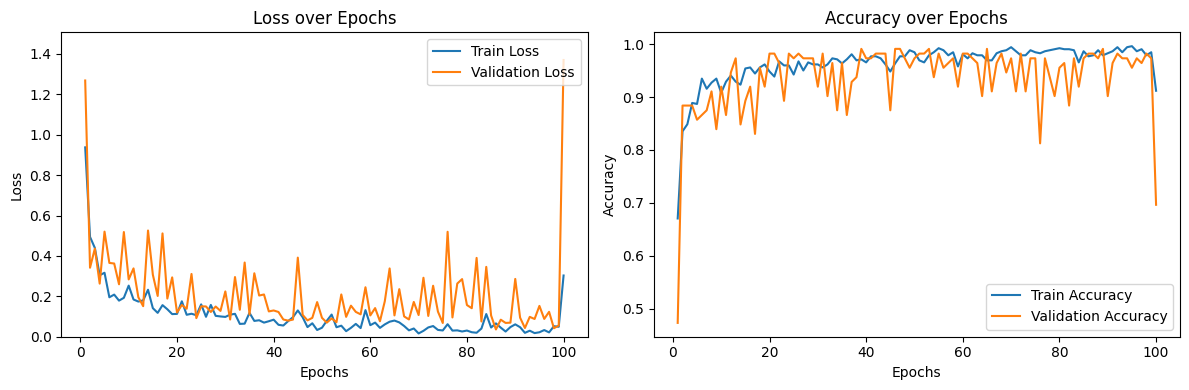

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(loc='upper right')
plt.ylim(0, max(max(train_loss_history), max(val_loss_history)) * 1.1)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [23]:
best_checkpoint_path = f"{checkpoints_path}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

In [24]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [25]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.973
Test Time: 0.31 seconds ---> 0.01 minutes


In [26]:
import numpy as np
from sklearn.metrics import classification_report

# --- Compute predictions ---
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Fix: Use only the actual classes in the test set ---
unique_classes = np.unique(y_true)
class_names = [str(i) for i in unique_classes]  # create names for only present classes

print("Classification Report:")
print(classification_report(y_true, y_pred, labels=unique_classes, target_names=class_names))

# --- Class-wise accuracy ---
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy

# Make sure num_classes matches the maximum label + 1
num_classes = int(max(unique_classes)) + 1
class_acc = class_accuracy(model, test_dataloader, num_classes)

for i in range(num_classes):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        60
           1       1.00      0.94      0.97        53

    accuracy                           0.97       113
   macro avg       0.98      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113

Class 0 Accuracy: 1.000
Class 1 Accuracy: 0.943


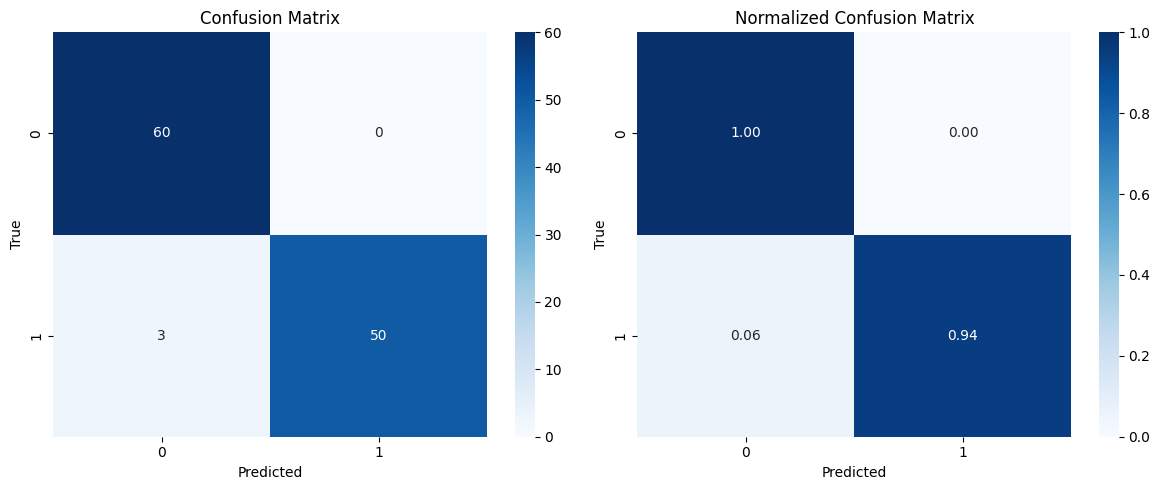

In [27]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

In [28]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        forward_handle = self.target_layer.register_forward_hook(forward_hook)
        backward_handle = self.target_layer.register_backward_hook(backward_hook)

        self.hook_handles.append(forward_handle)
        self.hook_handles.append(backward_handle)

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate_cam(self, input_tensor, target_class):
        self.model.eval()
        input_tensor.requires_grad_()  
    
        output = self.model(input_tensor)
        self.model.zero_grad()
    
        class_score = output[:, target_class]
        class_score.backward()
    
        gradients = self.gradients  
        activations = self.activations  
    
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  
    
        cam = torch.sum(weights * activations, dim=1) 
        cam = F.relu(cam)  
        cam = cam.squeeze().cpu().numpy()
        cam -= np.min(cam)
        cam /= (np.max(cam) + 1e-8)
        cam = np.power(cam, 0.5)  
        cam = cv2.resize(cam, (224, 224))
    
        return cam

In [29]:
def denormalize_image(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def show_gradcam(model, dataloader, device, target_layer, classes, num_samples=10,
                 mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225],
                 start_index=0):

    gradcam = GradCAM(model, target_layer)
    all_inputs = []
    all_labels = []

    for inputs, labels in dataloader:
        for i in range(inputs.size(0)):
            all_inputs.append(inputs[i])
            all_labels.append(labels[i])
        if len(all_inputs) >= start_index + num_samples:
            break

    if len(all_inputs) < start_index + num_samples:
        print("Not enough samples in the dataloader.")
        return

    plt.figure(figsize=(8, num_samples * 3))

    for idx in range(start_index, start_index + num_samples):
        input_tensor = all_inputs[idx].unsqueeze(0).to(device)
        label = all_labels[idx].to(device).item()
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()

        cam = gradcam.generate_cam(input_tensor, pred_class)

        input_denorm = denormalize_image(all_inputs[idx].clone().cpu(), mean, std)
        img_np = input_denorm.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        img_uint8 = np.uint8(255 * img_np)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(heatmap, 0.4, img_uint8, 0.6, 0)

        plt.subplot(num_samples, 2, 2 * (idx - start_index) + 1)
        plt.imshow(img_uint8)
        plt.title(f"Original\nLabel: {classes[label]}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * (idx - start_index) + 2)
        plt.imshow(overlay[..., ::-1])  
        plt.title(f"Grad-CAM\nPredicted Label: {classes[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    gradcam.remove_hooks()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


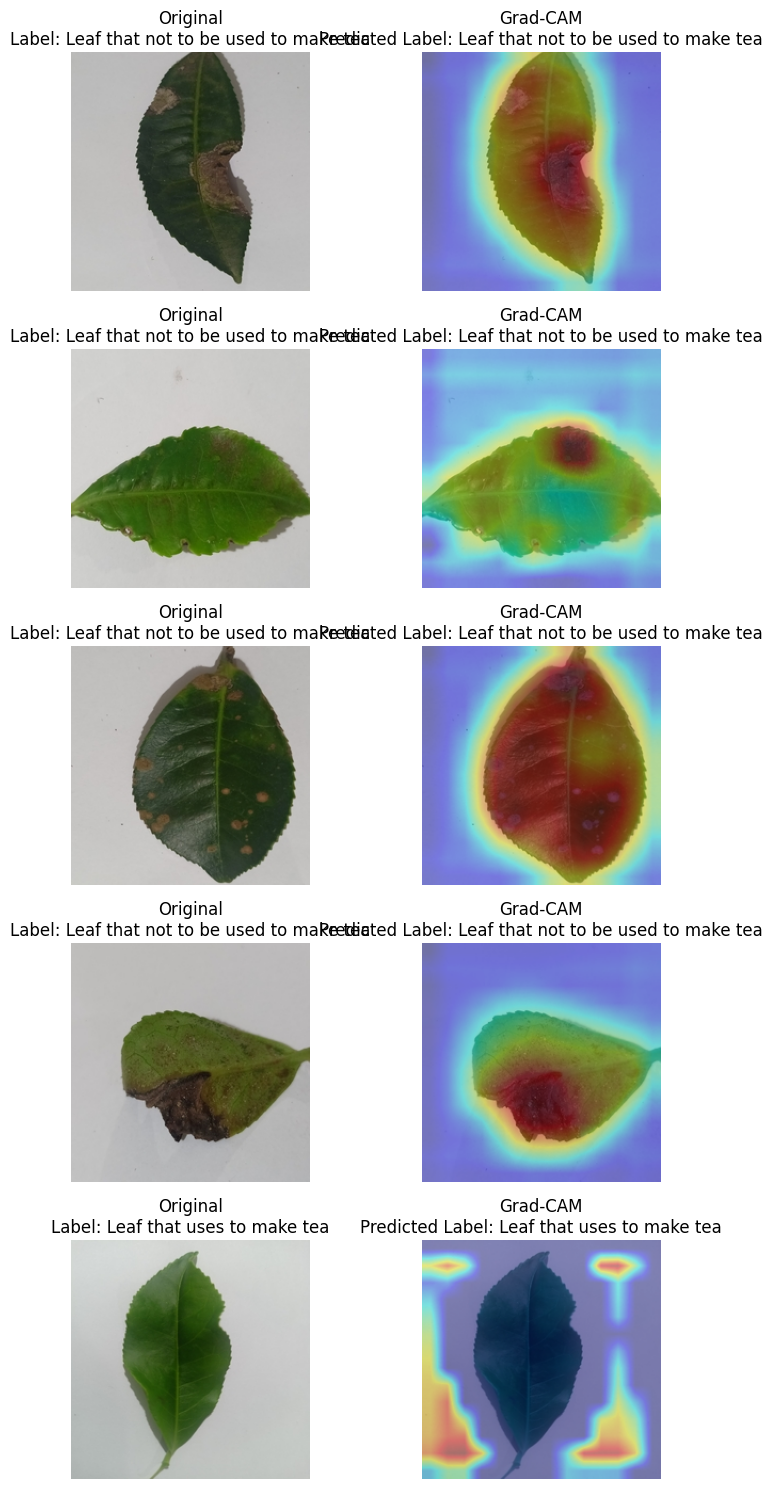

In [30]:
show_gradcam(
    model=model,
    dataloader=validation_dataloader,
    device=device,
    target_layer=model.features[16],
    classes=sorted(train_dataframe['label'].unique()),  
    num_samples=5,
    start_index=100  
)

In [31]:
def show_correct_gradcam(model, dataloader, device, target_layer, classes,
                         num_samples=5,
                         mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]):

    gradcam = GradCAM(model, target_layer)
    model.eval()

    correct_samples = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            for i in range(inputs.size(0)):
                if preds[i] == labels[i]:
                    correct_samples.append((inputs[i].cpu(), labels[i].item(), preds[i].item()))
                if len(correct_samples) >= num_samples:
                    break
            if len(correct_samples) >= num_samples:
                break

    plt.figure(figsize=(8, num_samples * 3))

    for idx, (img, label, pred) in enumerate(correct_samples):
        cam = gradcam.generate_cam(img.unsqueeze(0).to(device), pred)

        img_denorm = denormalize_image(img.clone(), mean, std)
        img_np = img_denorm.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        img_uint8 = np.uint8(255 * img_np)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(heatmap, 0.4, img_uint8, 0.6, 0)

        plt.subplot(num_samples, 2, 2 * idx + 1)
        plt.imshow(img_uint8)
        plt.title(f"Correct\nLabel: {classes[label]}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * idx + 2)
        plt.imshow(overlay[..., ::-1])
        plt.title(f"Grad-CAM\nPred: {classes[pred]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    gradcam.remove_hooks()


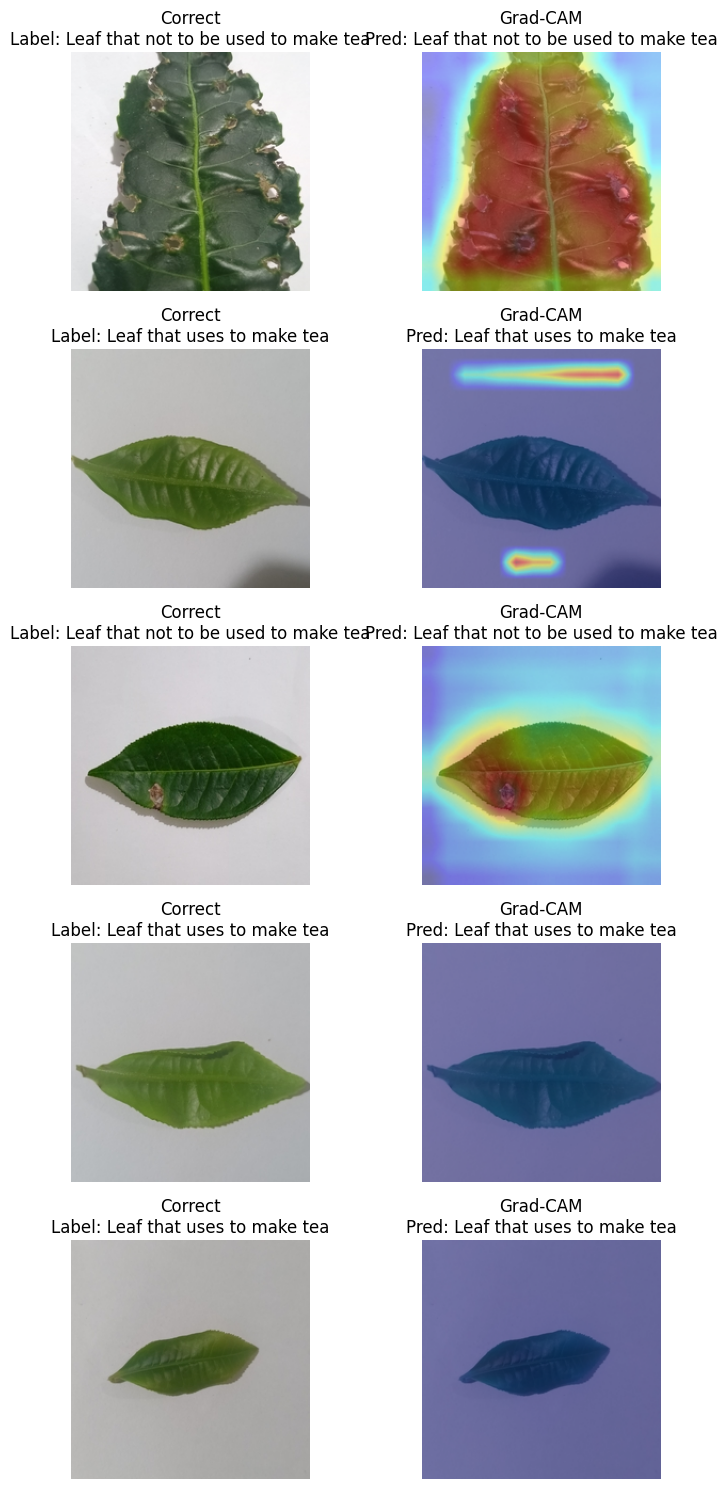

In [32]:
show_correct_gradcam(
    model=model,
    dataloader=validation_dataloader,
    device=device,
    target_layer=model.features[16],
    classes=sorted(train_dataframe['label'].unique()),
    num_samples=5
)


In [33]:
print(model)


TeaLeafNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [34]:
def show_incorrect_gradcam(model, dataloader, device, target_layer, classes,
                           num_samples=5,
                           mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225]):

    gradcam = GradCAM(model, target_layer)
    model.eval()

    incorrect_samples = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            for i in range(inputs.size(0)):
                if preds[i] != labels[i]:
                    incorrect_samples.append((inputs[i].cpu(), labels[i].item(), preds[i].item()))
                if len(incorrect_samples) >= num_samples:
                    break
            if len(incorrect_samples) >= num_samples:
                break

    plt.figure(figsize=(8, num_samples * 3))

    for idx, (img, label, pred) in enumerate(incorrect_samples):
        cam = gradcam.generate_cam(img.unsqueeze(0).to(device), pred)

        img_denorm = denormalize_image(img.clone(), mean, std)
        img_np = img_denorm.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        img_uint8 = np.uint8(255 * img_np)

        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(heatmap, 0.4, img_uint8, 0.6, 0)

        plt.subplot(num_samples, 2, 2 * idx + 1)
        plt.imshow(img_uint8)
        plt.title(f"Incorrect\nTrue: {classes[label]}")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2 * idx + 2)
        plt.imshow(overlay[..., ::-1])
        plt.title(f"Grad-CAM\nPred: {classes[pred]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    gradcam.remove_hooks()


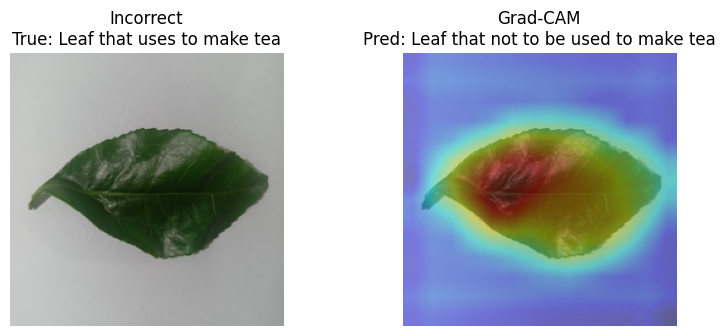

In [35]:
show_incorrect_gradcam(
    model=model,
    dataloader=validation_dataloader,
    device=device,
    target_layer=model.features[16],
    classes=sorted(train_dataframe['label'].unique()),
    num_samples=5
)
